###  Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import time
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

DATA_PATH = "human_activity"
WINDOW_SIZE = 120
STEP = 60

### Data Loading and Cleaning

In [2]:
def load_and_process_data(path):
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    data_frames = []
    
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            data_frames.append(df)
        except:
            pass
            
    if not data_frames:
        raise FileNotFoundError("No CSV files found in the specified path.")
        
    full_df = pd.concat(data_frames, axis=0, ignore_index=True)
    full_df.columns = [c.strip() for c in full_df.columns]
    
    sensor_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']
    for col in sensor_columns:
        full_df[col] = pd.to_numeric(full_df[col], errors='coerce')
    full_df.dropna(inplace=True)
    
    return full_df

def clean_label_name(label):
    parts = label.split('_')
    if parts[-1].isdigit():
        return "_".join(parts[:-1])
    return label

df = load_and_process_data(DATA_PATH)
df['Clean_Label'] = df['Label'].apply(clean_label_name)

le = LabelEncoder()
df['Label_ID'] = le.fit_transform(df['Clean_Label'])
LABEL_NAMES = le.classes_

X = []
y = []
sensor_cols = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']

for label in df['Label'].unique():
    subset = df[df['Label'] == label]
    data = subset[sensor_cols].values
    label_id = subset['Label_ID'].iloc[0]
    
    for i in range(0, len(data) - WINDOW_SIZE, STEP):
        window = data[i : i + WINDOW_SIZE]
        if len(window) == WINDOW_SIZE:
            X.append(window)
            y.append(label_id)

X = np.array(X, dtype='float32')
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Data Loaded. Classes: {LABEL_NAMES}")
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Data Loaded. Classes: ['Biceps_Curl' 'Dumbbell_ Shoulder_Shrug' 'Front_Raise' 'Lateral_Raise'
 'Sitting' 'Walking']
Training Shape: (3843, 120, 6)
Testing Shape: (961, 120, 6)


### Feature Extraction and Classic Models Evaluation

In [3]:
def extract_handcrafted_features(data):
    features = []
    for window in data:
        mean_vals = np.mean(window, axis=0)
        std_vals = np.std(window, axis=0)
        max_vals = np.max(window, axis=0)
        min_vals = np.min(window, axis=0)
        features.append(np.concatenate([mean_vals, std_vals, max_vals, min_vals]))
    return np.array(features)

X_train_feat = extract_handcrafted_features(X_train)
X_test_feat = extract_handcrafted_features(X_test)

results = []
trained_models = {}

models_ml = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME')
}

print("Evaluating Classic Machine Learning Models...")

for name, model in models_ml.items():
    start_train = time.time()
    model.fit(X_train_feat, y_train)
    train_time = time.time() - start_train
    
    start_pred = time.time()
    y_pred = model.predict(X_test_feat)
    pred_time = time.time() - start_pred
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    
    latency = pred_time / len(y_test)
    throughput = 1 / latency if latency > 0 else 0
    
    temp_file = "temp_model_size.pkl"
    joblib.dump(model, temp_file)
    model_size = os.path.getsize(temp_file) / 1024
    os.remove(temp_file)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1": f1,
        "Precision": prec,
        "Recall": rec,
        "Latency (s)": latency,
        "Throughput (req/s)": throughput,
        "Size (KB)": model_size
    })
    trained_models[name] = model

Evaluating Classic Machine Learning Models...


### Deep Learning Models Evaluation

In [4]:
print("Evaluating Deep Learning Models...")

scaler = StandardScaler()
X_train_dl = X_train.reshape(-1, X_train.shape[-1])
X_train_dl = scaler.fit_transform(X_train_dl).reshape(X_train.shape)
X_test_dl = X_test.reshape(-1, X_test.shape[-1])
X_test_dl = scaler.transform(X_test_dl).reshape(X_test.shape)

y_train_dl = to_categorical(y_train, len(LABEL_NAMES))
y_test_dl = to_categorical(y_test, len(LABEL_NAMES))

def build_cnn_model():
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(WINDOW_SIZE, 6)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(LABEL_NAMES), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model():
    model = Sequential([
        LSTM(64, input_shape=(WINDOW_SIZE, 6)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(len(LABEL_NAMES), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

dl_models_map = {"CNN": build_cnn_model(), "LSTM": build_lstm_model()}

for name, model in dl_models_map.items():
    start_train = time.time()
    model.fit(X_train_dl, y_train_dl, epochs=15, batch_size=32, validation_split=0.1, verbose=0)
    train_time = time.time() - start_train
    
    start_pred = time.time()
    y_pred_prob = model.predict(X_test_dl, verbose=0)
    pred_time = time.time() - start_pred
    
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    
    latency = pred_time / len(y_test)
    throughput = 1 / latency if latency > 0 else 0
    
    temp_file = "temp_model_dl.h5"
    model.save(temp_file)
    model_size = os.path.getsize(temp_file) / 1024
    os.remove(temp_file)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1": f1,
        "Precision": prec,
        "Recall": rec,
        "Latency (s)": latency,
        "Throughput (req/s)": throughput,
        "Size (KB)": model_size
    })
    trained_models[name] = model

Evaluating Deep Learning Models...


### Systematic Comparison and Visualization


=== SYSTEMATIC COMPARISON OF MODELS ===


,Model,Accuracy,Macro F1,Precision,Recall,Latency (s),Throughput (req/s),Size (KB)
1,XGBoost,0.936524,0.937247,0.937289,0.937440,0.000007,138722.678414,964.909180
3,CNN,0.936524,0.937373,0.940357,0.937099,0.000246,4058.784521,5729.835938
0,Random Forest,0.913632,0.914304,0.913884,0.915103,0.000015,68504.327810,7960.586914
4,LSTM,0.816857,0.819552,0.825027,0.817431,0.000575,1739.880036,300.468750
2,AdaBoost,0.734651,0.740087,0.752070,0.736576,0.000016,61162.425177,76.410156


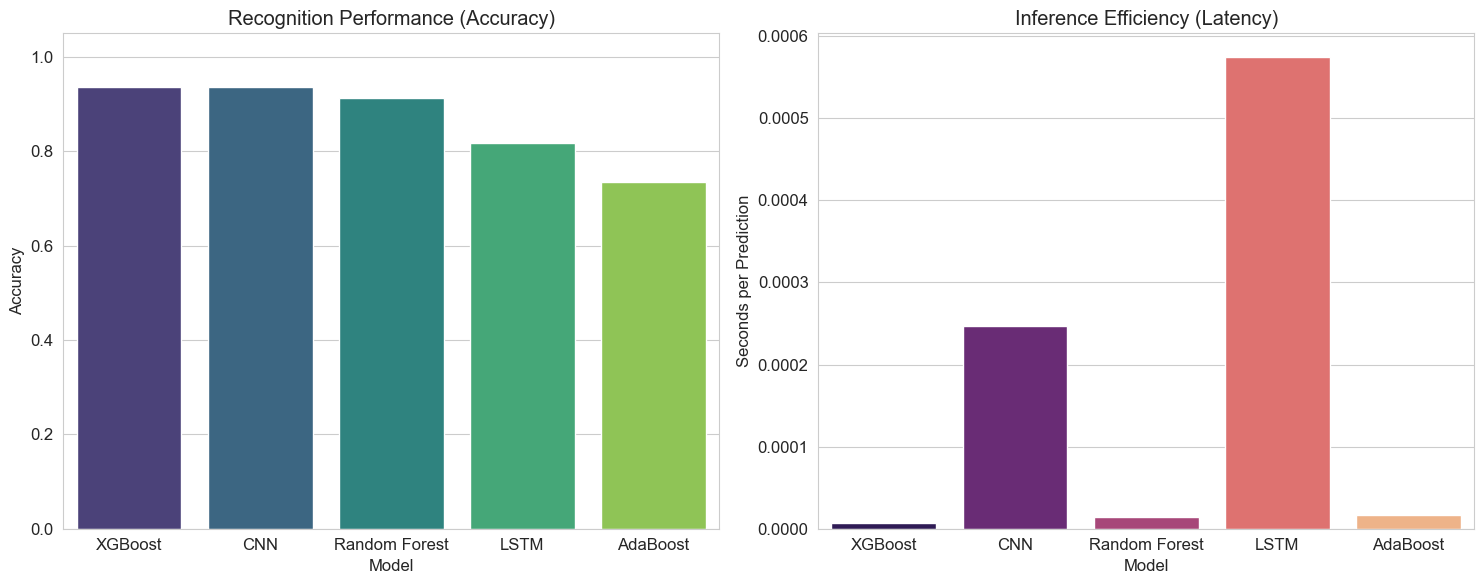

Top Performing Model: XGBoost


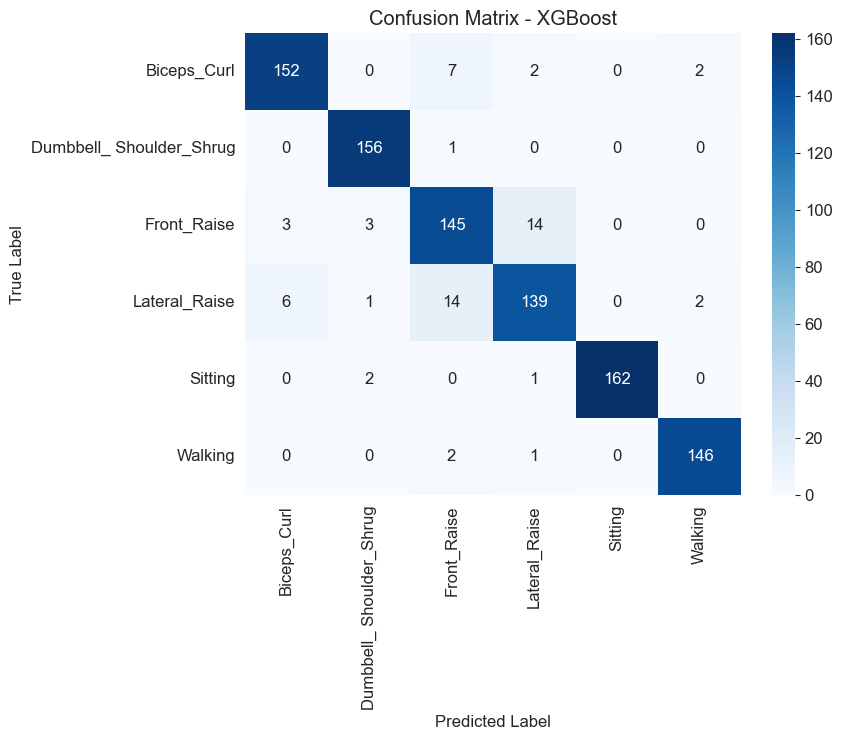

In [5]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print("\n=== SYSTEMATIC COMPARISON OF MODELS ===")
display(results_df)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis", ax=axes[0])
axes[0].set_title("Recognition Performance (Accuracy)")
axes[0].set_ylim(0, 1.05)

sns.barplot(x="Model", y="Latency (s)", data=results_df, palette="magma", ax=axes[1])
axes[1].set_title("Inference Efficiency (Latency)")
axes[1].set_ylabel("Seconds per Prediction")

plt.tight_layout()
plt.show()

best_model_name = results_df.iloc[0]['Model']
print(f"Top Performing Model: {best_model_name}")

if best_model_name in models_ml:
    y_pred_cm = trained_models[best_model_name].predict(X_test_feat)
else:
    y_pred_cm_prob = trained_models[best_model_name].predict(X_test_dl, verbose=0)
    y_pred_cm = np.argmax(y_pred_cm_prob, axis=1)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Saving Best Models (XGBoost & CNN)

In [6]:
print("Saving required models for Real-Time GUI compatibility...")

joblib.dump(scaler, 'scaler.pkl')
print("-> Saved: scaler.pkl (Required for Deep Learning models)")

if "XGBoost" in trained_models:
    joblib.dump(trained_models["XGBoost"], 'XGBoost_model.pkl')
    print("-> Saved: XGBoost_model.pkl")

if "CNN" in trained_models:
    trained_models["CNN"].save('cnn_model.h5')
    print("-> Saved: cnn_model.h5")

print("\nFiles are ready for real-time testing.")

Saving required models for Real-Time GUI compatibility...
-> Saved: scaler.pkl (Required for Deep Learning models)
-> Saved: XGBoost_model.pkl
-> Saved: cnn_model.h5

Files are ready for real-time testing.


In [7]:
print("Saving remaining models for comprehensive testing...")

if "Random Forest" in trained_models:
    joblib.dump(trained_models["Random Forest"], 'Random_Forest_model.pkl')
    print("-> Saved: Random_Forest_model.pkl")

if "AdaBoost" in trained_models:
    joblib.dump(trained_models["AdaBoost"], 'AdaBoost_model.pkl')
    print("-> Saved: AdaBoost_model.pkl")

if "LSTM" in trained_models:
    trained_models["LSTM"].save('lstm_model.h5')
    print("-> Saved: lstm_model.h5")

print("\nAll 5 models and Scaler have been successfully saved.")

Saving remaining models for comprehensive testing...
-> Saved: Random_Forest_model.pkl
-> Saved: AdaBoost_model.pkl
-> Saved: lstm_model.h5

All 5 models and Scaler have been successfully saved.
